# MODELO DE DEEP LEARN - ESPACIALIZAÇÃO

#### Configurando Dados

In [17]:
import pandas as pd

# Importando dados
df_aesa = pd.read_csv('aesa/aesa_2023_tratado.csv')

# Ajustando dados
df_aesa_t = df_aesa[(df_aesa['Ano'] >= 2015)][['Latitude', 'Longitude', 'Ano', 'Mês', 'Máximos']]

df_aesa_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18039 entries, 21 to 49366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   18039 non-null  float64
 1   Longitude  18039 non-null  float64
 2   Ano        18039 non-null  float64
 3   Mês        18039 non-null  float64
 4   Máximos    18039 non-null  float64
dtypes: float64(5)
memory usage: 845.6 KB


#### Exclusão de Outliers

In [18]:
import numpy as np

Q1 = df_aesa_t['Máximos'].quantile(0.25)
Q3 = df_aesa_t['Máximos'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Substituir outliers pela mediana
df_aesa_t['Máximos'] = np.where((df_aesa_t['Máximos'] < lower_bound) | (df_aesa_t['Máximos'] > upper_bound), 
                                    np.nan,
                                    df_aesa_t['Máximos'])

df_aesa_t = df_aesa_t.dropna()

#### Postos Pluviométricos de Treino e Teste

In [19]:
from sklearn.model_selection import train_test_split

# Criando coluna com localizações
df_aesa_t['Localizacao'] = df_aesa['Latitude'].astype(str) + ';' + df_aesa['Longitude'].astype(str)

# Separando localizações unicas
postos_pluviometricos = df_aesa_t['Localizacao'].unique()

# Separar a lista em duas listas com proporções de 70% e 20%
postos_treino, postos_teste = train_test_split(postos_pluviometricos, test_size=0.20, random_state=20)

# Verificar os tamanhos das listas resultantes
print(f'Tamanho da lista de treino: {len(postos_treino)}')
print(f'Tamanho da lista de teste : {len(postos_teste)}')

Tamanho da lista de treino: 193
Tamanho da lista de teste : 49


#### Coluna de Agrupamento

In [20]:
from sklearn.cluster import KMeans

# Separar os dados em variáveis de entrada (X) e saída (y)
X = df_aesa_t[['Latitude', 'Longitude', 'Ano', 'Mês']].values
y = df_aesa_t['Máximos'].values

# Treinar o modelo KMeans
kmeans = KMeans(n_clusters=8, random_state=42)
df_aesa_t_clusters = kmeans.fit_predict(X)

# Adicionar uma coluna com os rótulos de agrupamento ao conjunto de dados
df_aesa_t = pd.concat([df_aesa_t.reset_index(drop=True), pd.DataFrame(df_aesa_t_clusters, columns=['Cluster'])], axis=1)

#### Normalização de Dados

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Função de normalização
def normalization(df, columns):

    scaler = MinMaxScaler()

    scaler.fit(df[columns])

    df[columns] = scaler.transform(df[columns])

    return scaler, df

# Função de desnormalização
def denormalization(df, columns, scaler, column, data):

    df = df.drop(column, axis=1)

    df[column] = data
    
    df[columns] = scaler.inverse_transform(df[columns])

    return df[column]

# Aplicando função de normalização
scaler, df_aesa_t_n = normalization(df_aesa_t, ['Latitude', 'Longitude', 'Ano', 'Mês', 'Máximos', 'Cluster'])

# Adicionando coluna para distinção de postos
df_aesa_t_n['Localizacao']  = df_aesa_t['Localizacao'] 

#### Separação de Dados para Treino e Teste

In [22]:
def train_test(df, columns, column):
    
    # Definindo dados para X e Y
    df_postos_X = df[columns].values.reshape((df.shape[0], len(columns), 1))
    df_postos_y = df[column].values.reshape((df.shape[0], 1))

    return df_postos_X, df_postos_y

#### Treinamento de Modelo

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir dados de treino
df_treino = df_aesa_t_n[df_aesa_t_n['Localizacao'].isin(postos_treino)]
colunas = ['Latitude', 'Longitude', 'Ano', 'Mês', 'Cluster']
df_postos_treino_X, df_postos_treino_y = train_test(df_treino, colunas, 'Máximos')

# Definir o modelo de rede neural convolucional
cnn = Sequential([
            Conv1D(64, 3, activation='relu', input_shape=(df_postos_treino_X.shape[1], 
                                                          df_postos_treino_X.shape[2])),
            MaxPooling1D(2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dense(1)
                ])

# Compilar o modelo
cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse', 'mae'])

# Treinar o modelo
history = cnn.fit(df_postos_treino_X, df_postos_treino_y, epochs=500, validation_split=0.2, verbose=0)

c:\Users\alexa\Desktop\Ícones\Estudos\UFRN\Mestrado\03 - Matérias\dissertação\códigos\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Teste de Acurácia Geral 

In [24]:
def willmott_d(observed, predicted):

    observed = np.array(observed)
    predicted = np.array(predicted)
    
    # Calcula a média dos valores observados
    mean_observed = np.mean(observed)
    
    # Calcula o numerador
    numerator = np.sum(np.abs(predicted - observed))
    
    # Calcula o denominador
    denominator = np.sum(np.abs(predicted - mean_observed) + np.abs(observed - mean_observed))
    
    # Calcula o d de Willmott
    d = 1 - (numerator / denominator)
    
    return d

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

# Definir dados de teste
df_teste = df_aesa_t_n[df_aesa_t_n['Localizacao'].isin(postos_teste)]
X, y = train_test(df_teste, colunas, 'Máximos')

# Desnormalizar dados de teste
y = denormalization(df_teste, 
                    ['Latitude', 'Longitude', 'Ano', 'Mês', 'Máximos', 'Cluster'], 
                    scaler, 'Máximos', y)
y_pred = denormalization(df_teste, 
                         ['Latitude', 'Longitude', 'Ano', 'Mês', 'Máximos', 'Cluster'], 
                         scaler, 'Máximos', cnn.predict(X).flatten())

# DataFrame com Resultados dos Postos
df_postos_teste = df_aesa_t_n[df_aesa_t_n['Localizacao'].isin(postos_teste)].copy()
df_postos_teste['Máximos_DL'] = y_pred

# Calcular métricas
# print(f'\nMSE : {mean_squared_error(y, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred))}')
print(f'r²  : {r2_score(y, y_pred)}')
print(f'd   : {willmott_d(y, y_pred)}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 11.451383649727855
r²  : 0.7013714926158456
d   : 0.7614542449376


#### Teste de Acurácia Posto a Posto

In [26]:
df_resultados = []

for posto in postos_teste:
    
    # Definir dados de teste
    df_teste = df_aesa_t_n[df_aesa_t_n['Localizacao'] == posto]
    X, y = train_test(df_teste, colunas, 'Máximos')

    # Desnormalizar dados de teste
    y = denormalization(df_teste, 
                        ['Latitude', 'Longitude', 'Ano', 'Mês', 'Máximos', 'Cluster'], 
                        scaler, 'Máximos', y)
    y_pred = denormalization(df_teste, 
                            ['Latitude', 'Longitude', 'Ano', 'Mês', 'Máximos', 'Cluster'], 
                            scaler, 'Máximos', cnn.predict(X, verbose=0).flatten())

    # Criando DataFrame de Resultados
    df_resultados.append({'Posto': posto,
                         #'MSE': mean_squared_error(y, y_pred),
                          'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
                          'r²': r2_score(y, y_pred),
                          'd': willmott_d(y, y_pred)
                        })

df_resultados = pd.DataFrame(df_resultados).sort_values(by='Posto')

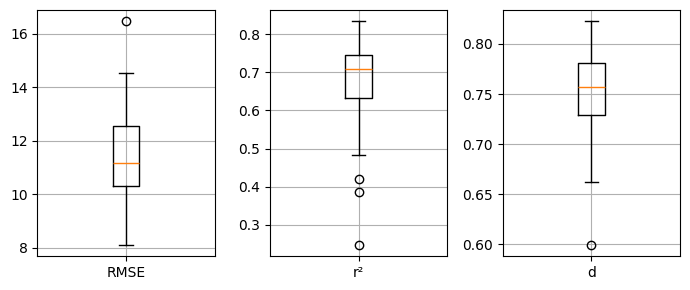

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(7, 3))  # 3 subplots lado a lado

for i, coluna in enumerate(['RMSE', 'r²', 'd']):
    axs[i].boxplot(df_resultados[coluna].values)
    axs[i].set_xticklabels([coluna], rotation=0)
    #axs[i].set_title(f'{coluna}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

#### Espacializando Dados

In [28]:
import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.read_file('aesa/brazil-states.geojson', encoding='utf-8')

# Filtrar para o estado específico (por exemplo, Paraíba)
estado_nome = 'Paraíba'
estado_gdf = gdf[gdf['name'] == estado_nome]

# Definir os limites da área de contorno
contorno = estado_gdf.geometry.iloc[0]
x_min, y_min, x_max, y_max = contorno.bounds

# Criar uma lista para armazenar os pontos dentro do contorno
pontos_dentro_contorno = []

# Definir a quantidade de pontos na grade
num_points = 200  # Aumente este número para uma grade mais fina

# Gerar os pontos dentro da área de contorno
for i in range(num_points):
    for j in range(num_points):
        x = x_min + i * (x_max - x_min) / (num_points - 1)
        y = y_min + j * (y_max - y_min) / (num_points - 1)
        point = Point(x, y)
        if contorno.contains(point):
            pontos_dentro_contorno.append((x, y))

In [29]:
# Criando DataFrame
latlon = []

for i in range(len(pontos_dentro_contorno)):
    for j in range(1, 13):
        for k in range(2015, 2024):
            latlon.append({'Latitude': pontos_dentro_contorno[i][1],
                           'Longitude': pontos_dentro_contorno[i][0],
                           'Ano': k,
                           'Mês': j})


df_esp = pd.DataFrame(latlon)

# Criando Cluster
df_esp['Cluster'] = kmeans.predict(df_esp[['Latitude', 'Longitude', 'Ano', 'Mês']])

c:\Users\alexa\Desktop\Ícones\Estudos\UFRN\Mestrado\03 - Matérias\dissertação\códigos\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [30]:
# Fragmentando DataFrame original
df_esp_graph = df_esp[['Latitude', 'Longitude', 'Ano', 'Mês', 'Cluster']].copy()

# Aplicando função de normalização
scaler_graph, df_esp_graph = normalization(df_esp_graph, ['Latitude', 'Longitude', 'Ano', 'Mês', 'Cluster'])

# Prevendo valores dos pontos determinados
y_graph = cnn.predict(df_esp_graph[colunas].values.reshape((df_esp_graph[colunas].shape[0], len(colunas), 1))).flatten()

# Aplicando função de desnormalização
df_esp_graph['Máximos'] = y_graph
y_graph = denormalization(df_esp_graph, 
                          ['Latitude', 'Longitude', 'Ano', 'Mês', 'Máximos', 'Cluster'], 
                          scaler, 'Máximos', 
                          y_graph)

# Adicionando valores de precipitação ao DataFrame original
df_esp['Máximos_C'] = y_graph

68334/68334 ━━━━━━━━━━━━━━━━━━━━ 116s 2ms/step


In [31]:
# Criar a coluna 'latlon' concatenando 'Latitude' e 'Longitude' como strings
df_esp['latlon'] = df_esp['Latitude'].astype(str) + ';' + df_esp['Longitude'].astype(str)

# Agrupar pelo 'latlon' e calcular o máximo de 'Máximos_C' para cada grupo
grouped = df_esp.groupby('latlon').agg({'Latitude': 'first',
                                        'Longitude': 'first',
                                        'Máximos_C': 'sum'}).reset_index(drop=True)

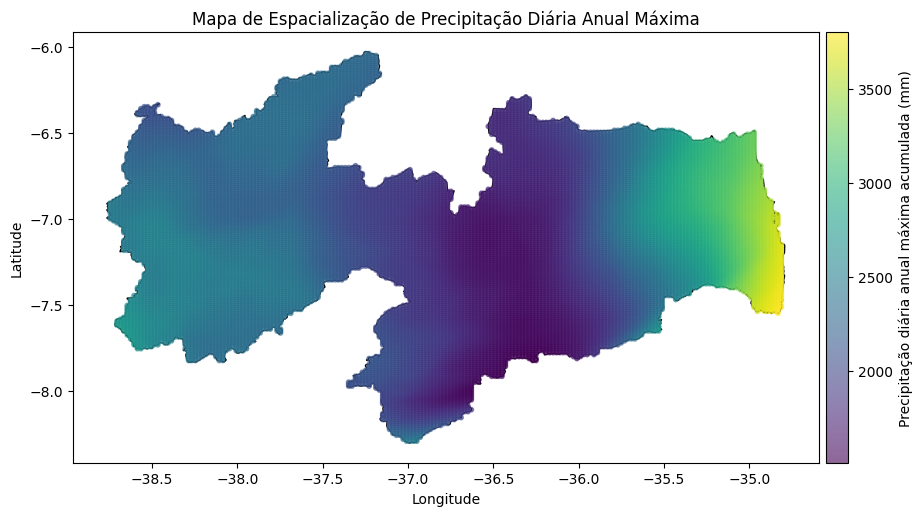

In [34]:
df_esp = grouped.copy()

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o mapa base do estado
estado_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plotar os dados preditos como uma imagem
scatter = ax.scatter(df_esp['Longitude'], df_esp['Latitude'], c=df_esp['Máximos_C'], cmap='viridis', alpha=0.6, s=10)

# Adicionar uma barra de cores
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
cbar.set_label('Precipitação diária anual máxima acumulada (mm)')

# Adicionar títulos e rótulos
plt.title('Mapa de Espacialização de Precipitação Diária Anual Máxima')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o mapa
plt.show()

#### Exportando Resultados

In [ ]:
# Exportanto Postos para Espacialização
df_esp.to_csv('dl_esp.csv')

# Exportando Acurácias
df_resultados.to_csv('dl_acc.csv')

# MODELO DE MACHINE LEARN - ESPACIALIZAÇÃO

#### Configurando Dados

In [96]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

# Importando dados
df_aesa = pd.read_csv('aesa/aesa_2023_tratado.csv')

# Criando DF para manipulação
df_aesa_t = df_aesa.copy()
df_aesa_t = df_aesa_t.drop(['Unnamed: 0'], axis=1)

# Restringindo para apenas 2015 em diante
df_aesa_t = df_aesa_t[(df_aesa_t['Ano'] >= 2015)]

# Definindo colunas necessárias
df_aesa_t = df_aesa_t[['Latitude', 'Longitude', 'Ano', 'Mês', 'Máximos']]

# Analisando informações
df_aesa_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18039 entries, 21 to 49366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   18039 non-null  float64
 1   Longitude  18039 non-null  float64
 2   Ano        18039 non-null  float64
 3   Mês        18039 non-null  float64
 4   Máximos    18039 non-null  float64
dtypes: float64(5)
memory usage: 845.6 KB


##### Configurando postos pluviométricos para treino e teste

In [97]:
# Criando coluna com localizações
df_aesa_t['Localizacao'] = df_aesa['Latitude'].astype(str) + ';' + df_aesa['Longitude'].astype(str)

# Separando localizações unicas
postos_pluviometricos = df_aesa_t['Localizacao'].unique()

# Separar a lista em duas listas com proporções de 70% e 20%
postos_treino, postos_teste = train_test_split(postos_pluviometricos, test_size=0.20, random_state=20)

# Verificar os tamanhos das listas resultantes
print(f'Tamanho da lista de treino: {len(postos_treino)}')
print(f'Tamanho da lista de teste: {len(postos_teste)}')

Tamanho da lista de treino: 193
Tamanho da lista de teste: 49


##### Adicionando coluna de agrupamento

In [98]:
from sklearn.cluster import KMeans

# Separar os dados em variáveis de entrada (X) e saída (y)
X = df_aesa_t[['Latitude', 'Longitude', 'Ano']].values
y = df_aesa_t['Máximos'].values

# Treinar o modelo KMeans
kmeans = KMeans(n_clusters=8, random_state=42)
df_aesa_t_clusters = kmeans.fit_predict(X)

# Adicionar uma coluna com os rótulos de agrupamento ao conjunto de dados normalizado
df_aesa_t_clustered = pd.concat([df_aesa_t.reset_index(drop=True), pd.DataFrame(df_aesa_t_clusters, columns=['Cluster'])], axis=1)

##### Separando dados para treino e teste

In [99]:
# Definindo DataFrame que postos de treino
df_postos_treino = df_aesa_t_clustered[df_aesa_t_clustered['Localizacao'].isin(postos_treino)]

# Definindo dados para X e Y
df_postos_treino_X = df_postos_treino[['Latitude', 'Longitude', 'Ano', 'Mês', 'Cluster']].values
df_postos_treino_y = df_postos_treino['Máximos'].values

#### Treinando modelo

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold

# Definir os parâmetros a serem ajustados
param_grid = {
    'n_estimators': [200],
    'max_features': [2],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [False]
}

# Criar o modelo ExtraTreesRegressor
model = ExtraTreesRegressor()

# Definir a estratégia de validação cruzada (KFold com 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Executar a busca em grade
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='r2', verbose=0)
grid_search.fit(df_postos_treino_X, df_postos_treino_y)

print('Modelo treinado com sucesso!')

Modelo treinado com sucesso!


#### Prevendo acurácia geral

In [101]:
def willmott_d(observed, predicted):

    observed = np.array(observed)
    predicted = np.array(predicted)
    
    # Calcula a média dos valores observados
    mean_observed = np.mean(observed)
    
    # Calcula o numerador
    numerator = np.sum(np.abs(predicted - observed))
    
    # Calcula o denominador
    denominator = np.sum(np.abs(predicted - mean_observed) + np.abs(observed - mean_observed))
    
    # Calcula o d de Willmott
    d = 1 - (numerator / denominator)
    
    return d

In [102]:
from sklearn.metrics import mean_squared_error, r2_score

# Obter o melhor modelo
best_model = grid_search.best_estimator_

# Definindo dados para treinamento
X = df_aesa_t_clustered[df_aesa_t_clustered['Localizacao'].isin(postos_teste)][['Latitude', 'Longitude', 'Ano', 'Mês', 'Cluster']].values
y = df_aesa_t_clustered[df_aesa_t_clustered['Localizacao'].isin(postos_teste)]['Máximos'].values

# Fazendo predição
y_pred = best_model.predict(X)

# DataFrame com Resultados dos Postos
df_postos_teste = df_aesa_t_clustered[df_aesa_t_clustered['Localizacao'].isin(postos_teste)].copy()
df_postos_teste['Máximos_ML'] = y_pred

# Calcular métricas
# print(f'\nMSE : {mean_squared_error(y, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred))}')
print(f'r²  : {r2_score(y, y_pred)}')
print(f'd²  : {willmott_d(y, y_pred)}')

RMSE: 13.684519734268894
r²  : 0.7221684516856857
d²  : 0.7886261946183784


##### Analisando acurácia posto a posto

In [103]:
df_resultados = []

for posto in postos_teste:

    # Obter o melhor modelo
    best_model = grid_search.best_estimator_

    # Definindo dados para treinamento
    X = df_aesa_t_clustered[df_aesa_t_clustered['Localizacao'] == posto][['Latitude', 'Longitude', 'Ano', 'Mês', 'Cluster']].values
    y = df_aesa_t_clustered[df_aesa_t_clustered['Localizacao'] == posto]['Máximos'].values

    # Fazendo predição
    y_pred = best_model.predict(X)

    # Informações de precisão
    df_resultados.append({'Posto': posto,
                         #'MSE': mean_squared_error(y, y_pred),
                          'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
                          'r²': r2_score(y, y_pred),
                          'd': willmott_d(y, y_pred)
                        })

df_resultados = pd.DataFrame(df_resultados).sort_values(by='Posto')

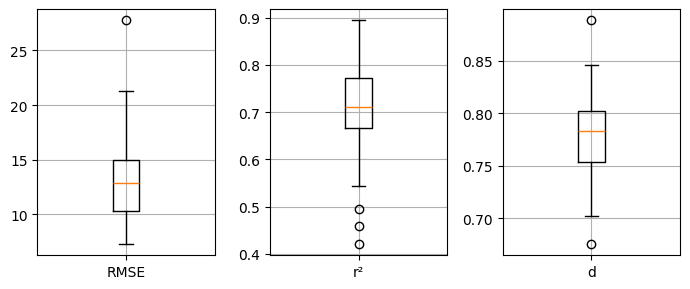

In [104]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(7, 3))  # 3 subplots lado a lado

for i, coluna in enumerate(['RMSE', 'r²', 'd']):
    axs[i].boxplot(df_resultados[coluna].values)
    axs[i].set_xticklabels([coluna], rotation=0)
    #axs[i].set_title(f'{coluna}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

#### Espacializando Dados

In [112]:
import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.read_file('aesa/brazil-states.geojson', encoding='utf-8')

# Filtrar para o estado específico (por exemplo, Paraíba)
estado_nome = 'Paraíba'
estado_gdf = gdf[gdf['name'] == estado_nome]

# Definir os limites da área de contorno
contorno = estado_gdf.geometry.iloc[0]
x_min, y_min, x_max, y_max = contorno.bounds

# Criar uma lista para armazenar os pontos dentro do contorno
pontos_dentro_contorno = []

# Definir a quantidade de pontos na grade
num_points = 200  # Aumente este número para uma grade mais fina

# Gerar os pontos dentro da área de contorno
for i in range(num_points):
    for j in range(num_points):
        x = x_min + i * (x_max - x_min) / (num_points - 1)
        y = y_min + j * (y_max - y_min) / (num_points - 1)
        point = Point(x, y)
        if contorno.contains(point):
            pontos_dentro_contorno.append((x, y))

In [116]:
# Criando DataFrame com malha da Paraíba
latlon = []

for i in range(len(pontos_dentro_contorno)):
    for j in range(1, 13):
        for k in range(2015, 2024):
            latlon.append({'Latitude': pontos_dentro_contorno[i][1],
                           'Longitude': pontos_dentro_contorno[i][0],
                           'Ano': k,
                           'Mês': j})


df_esp = pd.DataFrame(latlon)

# Criando Cluster
df_esp['Cluster'] = kmeans.predict(df_esp[['Latitude', 'Longitude', 'Ano']])

# Prever os valores de precipitação para os pontos da grade
z_grid_pred = best_model.predict(df_esp[['Latitude', 'Longitude', 'Ano', 'Mês', 'Cluster']].values)

# Adicionar as previsões ao DataFrame
df_esp['Máximos_C'] = z_grid_pred

c:\Users\alexa\Desktop\Ícones\Estudos\UFRN\Mestrado\03 - Matérias\dissertação\códigos\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [114]:
# Criar a coluna 'latlon' concatenando 'Latitude' e 'Longitude' como strings
df_esp['latlon'] = df_esp['Latitude'].astype(str) + ';' + df_esp['Longitude'].astype(str)

# Agrupar pelo 'latlon' e calcular o máximo de 'Máximos_C' para cada grupo
grouped = df_esp.groupby('latlon').agg({'Latitude': 'first',
                                        'Longitude': 'first',
                                        'Máximos_C': 'sum'}).reset_index(drop=True)

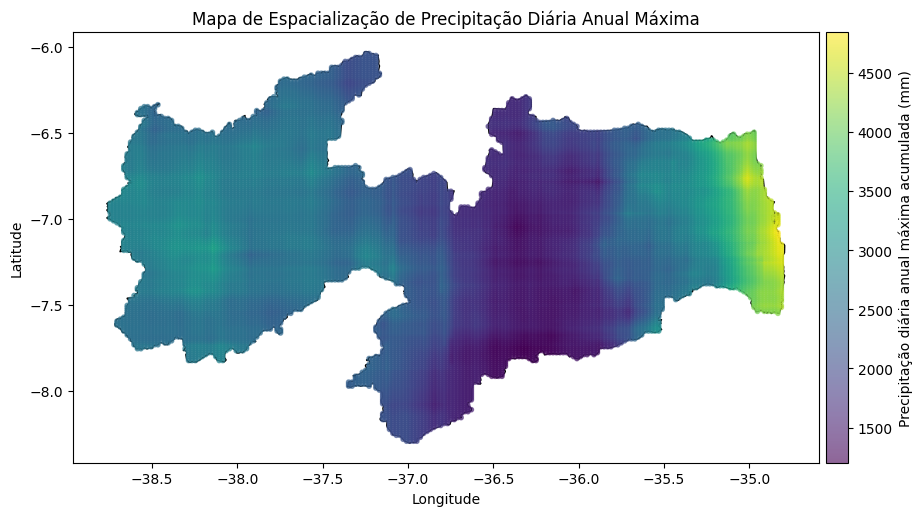

In [117]:
df_esp = grouped.copy()

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o mapa base do estado
estado_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plotar os dados preditos como uma imagem
scatter = ax.scatter(df_esp['Longitude'], df_esp['Latitude'], c=df_esp['Máximos_C'], cmap='viridis', alpha=0.6, s=10)

# Adicionar uma barra de cores
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
cbar.set_label('Precipitação diária anual máxima acumulada (mm)')

# Adicionar títulos e rótulos
plt.title('Mapa de Espacialização de Precipitação Diária Anual Máxima')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o mapa
plt.show()

#### Exportando Resultados

# MÉTODO IDW - ESPACIALIZAÇÃO

#### Configurando Dados

In [1]:
import pandas as pd

# Importando dados
df_aesa = pd.read_csv('aesa/aesa_2023_tratado.csv')

# Ajustando dados
df_aesa_t = df_aesa[['Município/Posto', 'Bacia', 'Latitude', 'Longitude', 'Altitude', 'Ano', 'Mês', 'Máximos']]

df_aesa_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49367 entries, 0 to 49366
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Município/Posto  49367 non-null  object 
 1   Bacia            49367 non-null  object 
 2   Latitude         49367 non-null  float64
 3   Longitude        49367 non-null  float64
 4   Altitude         49367 non-null  float64
 5   Ano              49367 non-null  float64
 6   Mês              49367 non-null  float64
 7   Máximos          49367 non-null  float64
dtypes: float64(6), object(2)
memory usage: 3.0+ MB


#### Postos Pluviométricos de Treino e Teste

In [2]:
from sklearn.model_selection import train_test_split

# Criando coluna com localizações
df_aesa_t['Localizacao'] = df_aesa['Latitude'].astype(str) + ';' + df_aesa['Longitude'].astype(str)

# Separando localizações unicas
postos_pluviometricos = df_aesa_t['Localizacao'].unique()

# Separar a lista em duas listas com proporções de 70% e 20%
postos_treino, postos_teste = train_test_split(postos_pluviometricos, test_size=0.20, random_state=20)

# Verificar os tamanhos das listas resultantes
print(f'Tamanho da lista de treino: {len(postos_treino)}')
print(f'Tamanho da lista de teste : {len(postos_teste)}')

Tamanho da lista de treino: 193
Tamanho da lista de teste : 49


#### Calculando Método IDW

In [3]:
from IPython.display import clear_output

import numpy as np

# Restringindo para apenas 2015 em diante
df_aesa_idw = df_aesa_t[df_aesa_t['Ano'] >= 2015].copy()

def idw(postos_teste, df, df_treino, t=1):
    novos_valores_idw = []

    df = df[df['Localizacao'].isin(postos_treino)]

    df['Latitude'] = df['Latitude'].astype(float)
    df['Longitude'] = df['Longitude'].astype(float)

    t_i = len(postos_teste)

    for i, posto in enumerate(postos_teste):
        print(f'Faltam {i+1} de {t_i}.')

        # Definindo localização do posto calculado
        lat, lon = map(float, posto.split(';'))

        # Filtrando uma vez e convertendo colunas apenas uma vez
        df['Distancia'] = np.sqrt((df['Latitude'] - lat) ** 2 + (df['Longitude'] - lon) ** 2)
        
        # Definindo menores distancias
        menores_distancias = np.sort(df['Distancia'].unique())
        
        # Definindo datas para descobrir séries do posto
        df_posto_atual = df_treino[df_treino['Localizacao'] == posto]
        
        # Definindo localizações com menores distancias
        df_menores_distancias = df[df['Distancia'].isin(menores_distancias)]

        # Calculando método idw para posto em análise
        for _, row in df_posto_atual.iterrows():
            ano_idw = row['Ano']
            mes_idw = row['Mês']

            informacoes_do_ano_mes = df_menores_distancias[(df_menores_distancias['Ano'] == ano_idw) & (df_menores_distancias['Mês'] == mes_idw)]
            
            # Verificar se há dados para o cálculo
            if not informacoes_do_ano_mes.empty:
                maximos_idw = (informacoes_do_ano_mes['Máximos'] / (informacoes_do_ano_mes['Distancia'] ** 2)).sum() / (1 / (informacoes_do_ano_mes['Distancia'] ** 2)).sum()

                novo_valor = {
                    'Latitude': lat,
                    'Longitude': lon,
                    'Ano': ano_idw,
                    'Mes': mes_idw,
                    'Máximos_IDW': maximos_idw,
                    'Posto': posto
                }

                if t == 0:
                    novo_valor['Máximos'] = row['Máximos']

                novos_valores_idw.append(novo_valor)

        clear_output(wait=True)
            
    return novos_valores_idw

#### Verificando DataFrame Resultante

In [4]:
# DataFrame dos resultados gerados
df_novos_valores_idw = pd.DataFrame(idw(postos_teste, 
                                        df_aesa_t, 
                                        df_aesa_t[df_aesa_t['Localizacao'].isin(postos_teste)], 
                                        0))

'''

# Caso se queira verificação de quantidade de linhas afim de comparar resultado

df_aesa_t[df_aesa_t['Localizacao'].isin(postos_teste)]

'''

# Observando informações do DataFrame
df_novos_valores_idw = df_novos_valores_idw.dropna()
df_novos_valores_idw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10066 entries, 0 to 10065
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     10066 non-null  float64
 1   Longitude    10066 non-null  float64
 2   Ano          10066 non-null  float64
 3   Mes          10066 non-null  float64
 4   Máximos_IDW  10066 non-null  float64
 5   Posto        10066 non-null  object 
 6   Máximos      10066 non-null  float64
dtypes: float64(6), object(1)
memory usage: 550.6+ KB


###### É importante destacar que alguns valores no calculo do IDW retornaram NAN. O que causa isso é a falta de dados para o ano e mês dos postos vizinhos interpolarem e resultarem no posto que se deseja. Para contornar isto, basta aumentar o número de postos ao redor do posto principal que se deseja interpolar. Contudo, é importante checar se a precisão da predição geral irá cair ou aumentar conforme se aumenta o número de postos que se interpolam ao redor.

#### Teste de Acurácia Geral 

In [5]:
def willmott_d(observed, predicted):

    observed = np.array(observed)
    predicted = np.array(predicted)
    
    # Calcula a média dos valores observados
    mean_observed = np.mean(observed)
    
    # Calcula o numerador
    numerator = np.sum(np.abs(predicted - observed))
    
    # Calcula o denominador
    denominator = np.sum(np.abs(predicted - mean_observed) + np.abs(observed - mean_observed))
    
    # Calcula o d de Willmott
    d = 1 - (numerator / denominator)
    
    return d

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import HydroErr as he

# Calcular métricas
# print(f'\nMSE : {mean_squared_error(df_novos_valores_idw['Máximos'].values, df_novos_valores_idw['Máximos_IDW'].values)}')
print(f'RMSE: {np.sqrt(mean_squared_error(df_novos_valores_idw['Máximos'].values, df_novos_valores_idw['Máximos_IDW'].values))}')
print(f'r²  : {r2_score(df_novos_valores_idw['Máximos'].values, df_novos_valores_idw['Máximos_IDW'].values)}')
# print(f'NSE : {he.nse(df_novos_valores_idw['Máximos_IDW'].values, df_novos_valores_idw['Máximos'].values)}')
print(f'd   : {willmott_d(df_novos_valores_idw['Máximos'].values, df_novos_valores_idw['Máximos_IDW'].values)}')

RMSE: 14.778147868787027
r²  : 0.6895869633883214
d   : 0.7616894853815019


#### Teste de Acurácia Posto a Posto

In [7]:
df_resultados = []

for posto in postos_teste:

    medidas_idw = [mean_squared_error(df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos'].values, 
                                      df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos_IDW'].values),
                   np.sqrt(mean_squared_error(df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos'].values, 
                                              df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos_IDW'].values)),
                   r2_score(df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos'].values, 
                            df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos_IDW'].values),
                   willmott_d(df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos'].values, 
                              df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos_IDW'].values)]
        
    df_resultados.append({'Posto': posto,
                         #'MSE': medidas_idw[0],
                          'RMSE': medidas_idw[1],
                          'r²': medidas_idw[2],
                         #'NSE': medidas_idw[3],
                          'd': medidas_idw[3]
                        })

df_resultados = pd.DataFrame(df_resultados).sort_values(by='Posto')

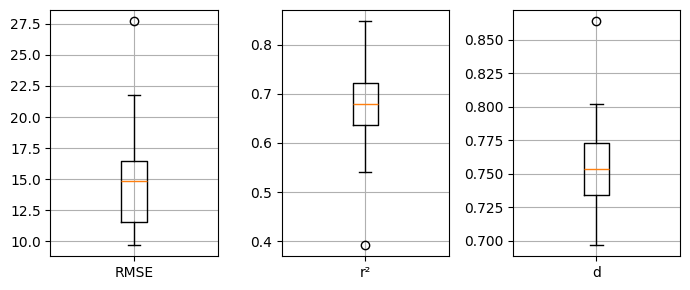

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(7, 3))  # 3 subplots lado a lado

for i, coluna in enumerate(['RMSE', 'r²', 'd']):
    axs[i].boxplot(df_resultados[coluna].values)
    axs[i].set_xticklabels([coluna], rotation=0)
    #axs[i].set_title(f'{coluna}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

#### Espacializando Dados

In [9]:
import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.read_file('aesa/brazil-states.geojson', encoding='utf-8')

# Filtrar para o estado específico (por exemplo, Paraíba)
estado_nome = 'Paraíba'
estado_gdf = gdf[gdf['name'] == estado_nome]

# Definir os limites da área de contorno
contorno = estado_gdf.geometry.iloc[0]
x_min, y_min, x_max, y_max = contorno.bounds

# Criar uma lista para armazenar os pontos dentro do contorno
pontos_dentro_contorno = []

# Definir a quantidade de pontos na grade
num_points = 200  # Aumente este número para uma grade mais fina

# Gerar os pontos dentro da área de contorno
for i in range(num_points):
    for j in range(num_points):
        x = x_min + i * (x_max - x_min) / (num_points - 1)
        y = y_min + j * (y_max - y_min) / (num_points - 1)
        point = Point(x, y)
        if contorno.contains(point):
            pontos_dentro_contorno.append((x, y))

In [12]:
# Criando DataFrame
latlon = []

for i in range(len(pontos_dentro_contorno)):
    for j in range(1, 13):
        for k in range(2015, 2024):
            latlon.append({'Latitude': pontos_dentro_contorno[i][1],
                           'Longitude': pontos_dentro_contorno[i][0],
                           'Ano': k,
                           'Mês': j})

df_esp = pd.DataFrame(latlon)

# Criar a coluna 'latlon' concatenando 'Latitude' e 'Longitude' como strings
df_esp['Localizacao'] = df_esp['Latitude'].astype(str) + ';' + df_esp['Longitude'].astype(str)

# Prever os valores de precipitação para os pontos da grade
df_novos_valores = idw(df_esp['Localizacao'].unique(), df_aesa_t, df_esp, 1)

Faltam 20247 de 20247.


In [14]:
novos_valores_idw = pd.DataFrame(df_novos_valores)

novos_valores_idw['Máximos_C'] = novos_valores_idw['Máximos_IDW'] 
novos_valores_idw['Latitude'] = novos_valores_idw['Latitude'].astype(float)
novos_valores_idw['Longitude'] = novos_valores_idw['Longitude'].astype(float)

# Agrupar pelo 'latlon' e calcular o máximo de 'Máximos_C' para cada grupo
grouped = novos_valores_idw.groupby('Posto').agg({'Latitude': 'first',
                                                  'Longitude': 'first',
                                                  'Máximos_C': 'sum'}).reset_index(drop=True)

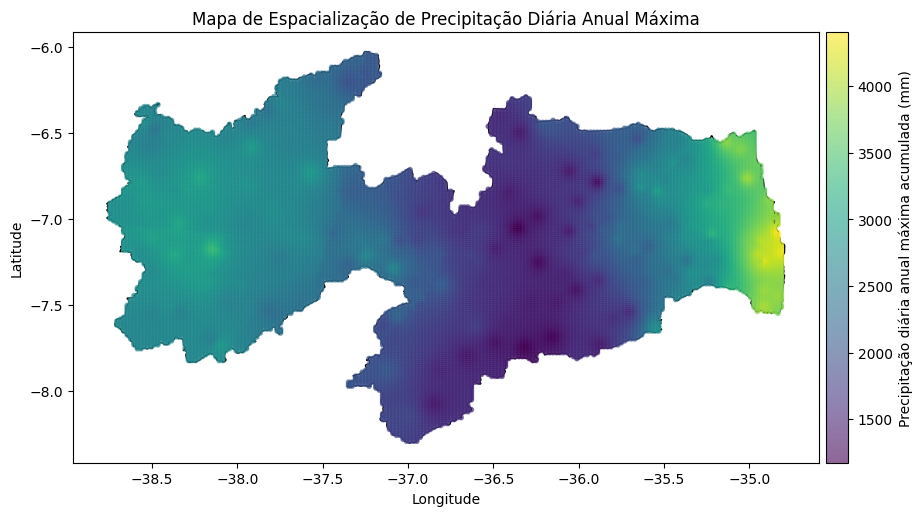

In [15]:
df_esp = grouped.copy()

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o mapa base do estado
estado_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plotar os dados preditos como uma imagem
scatter = ax.scatter(df_esp['Longitude'], df_esp['Latitude'], c=df_esp['Máximos_C'], cmap='viridis', alpha=0.6, s=10)

# Adicionar uma barra de cores
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
cbar.set_label('Precipitação diária anual máxima acumulada (mm)')

# Adicionar títulos e rótulos
plt.title('Mapa de Espacialização de Precipitação Diária Anual Máxima')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o mapa
plt.show()

In [20]:
len(novos_valores_idw['Posto'].unique())

20247

#### Exportando Resultados

In [16]:
# Exportanto Postos para Espacialização
df_esp.to_csv('results/idw_esp.csv')

# Exportando Acurácias
df_resultados.to_csv('results/idw_acc.csv')

In [118]:
# Exportanto Postos para Espacialização
df_esp.to_csv('results/ml_esp.csv')

# Exportando Acurácias
df_resultados.to_csv('results/ml_acc.csv')

# MÉTODO IDW - ESPACIALIZAÇÃO

#### Configurando Dados

In [1]:
import pandas as pd

# Importando dados
df_aesa = pd.read_csv('aesa/aesa_2023_tratado.csv')

# Ajustando dados
df_aesa_t = df_aesa[['Município/Posto', 'Bacia', 'Latitude', 'Longitude', 'Altitude', 'Ano', 'Mês', 'Máximos']]

df_aesa_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49367 entries, 0 to 49366
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Município/Posto  49367 non-null  object 
 1   Bacia            49367 non-null  object 
 2   Latitude         49367 non-null  float64
 3   Longitude        49367 non-null  float64
 4   Altitude         49367 non-null  float64
 5   Ano              49367 non-null  float64
 6   Mês              49367 non-null  float64
 7   Máximos          49367 non-null  float64
dtypes: float64(6), object(2)
memory usage: 3.0+ MB


#### Postos Pluviométricos de Treino e Teste

In [2]:
from sklearn.model_selection import train_test_split

# Criando coluna com localizações
df_aesa_t['Localizacao'] = df_aesa['Latitude'].astype(str) + ';' + df_aesa['Longitude'].astype(str)

# Separando localizações unicas
postos_pluviometricos = df_aesa_t['Localizacao'].unique()

# Separar a lista em duas listas com proporções de 70% e 20%
postos_treino, postos_teste = train_test_split(postos_pluviometricos, test_size=0.20, random_state=20)

# Verificar os tamanhos das listas resultantes
print(f'Tamanho da lista de treino: {len(postos_treino)}')
print(f'Tamanho da lista de teste : {len(postos_teste)}')

Tamanho da lista de treino: 193
Tamanho da lista de teste : 49


#### Calculando Método IDW

In [3]:
from IPython.display import clear_output

import numpy as np

# Restringindo para apenas 2015 em diante
df_aesa_idw = df_aesa_t[df_aesa_t['Ano'] >= 2015].copy()

def idw(postos_teste, df, df_treino, t=1):
    novos_valores_idw = []

    df = df[df['Localizacao'].isin(postos_treino)]

    df['Latitude'] = df['Latitude'].astype(float)
    df['Longitude'] = df['Longitude'].astype(float)

    t_i = len(postos_teste)

    for i, posto in enumerate(postos_teste):
        print(f'Faltam {i+1} de {t_i}.')

        # Definindo localização do posto calculado
        lat, lon = map(float, posto.split(';'))

        # Filtrando uma vez e convertendo colunas apenas uma vez
        df['Distancia'] = np.sqrt((df['Latitude'] - lat) ** 2 + (df['Longitude'] - lon) ** 2)
        
        # Definindo menores distancias
        menores_distancias = np.sort(df['Distancia'].unique())
        
        # Definindo datas para descobrir séries do posto
        df_posto_atual = df_treino[df_treino['Localizacao'] == posto]
        
        # Definindo localizações com menores distancias
        df_menores_distancias = df[df['Distancia'].isin(menores_distancias)]

        # Calculando método idw para posto em análise
        for _, row in df_posto_atual.iterrows():
            ano_idw = row['Ano']
            mes_idw = row['Mês']

            informacoes_do_ano_mes = df_menores_distancias[(df_menores_distancias['Ano'] == ano_idw) & (df_menores_distancias['Mês'] == mes_idw)]
            
            # Verificar se há dados para o cálculo
            if not informacoes_do_ano_mes.empty:
                maximos_idw = (informacoes_do_ano_mes['Máximos'] / (informacoes_do_ano_mes['Distancia'] ** 2)).sum() / (1 / (informacoes_do_ano_mes['Distancia'] ** 2)).sum()

                novo_valor = {
                    'Latitude': lat,
                    'Longitude': lon,
                    'Ano': ano_idw,
                    'Mes': mes_idw,
                    'Máximos_IDW': maximos_idw,
                    'Posto': posto
                }

                if t == 0:
                    novo_valor['Máximos'] = row['Máximos']

                novos_valores_idw.append(novo_valor)

        clear_output(wait=True)
            
    return novos_valores_idw

#### Verificando DataFrame Resultante

In [4]:
# DataFrame dos resultados gerados
df_novos_valores_idw = pd.DataFrame(idw(postos_teste, 
                                        df_aesa_t, 
                                        df_aesa_t[df_aesa_t['Localizacao'].isin(postos_teste)], 
                                        0))

'''

# Caso se queira verificação de quantidade de linhas afim de comparar resultado

df_aesa_t[df_aesa_t['Localizacao'].isin(postos_teste)]

'''

# Observando informações do DataFrame
df_novos_valores_idw = df_novos_valores_idw.dropna()
df_novos_valores_idw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10066 entries, 0 to 10065
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     10066 non-null  float64
 1   Longitude    10066 non-null  float64
 2   Ano          10066 non-null  float64
 3   Mes          10066 non-null  float64
 4   Máximos_IDW  10066 non-null  float64
 5   Posto        10066 non-null  object 
 6   Máximos      10066 non-null  float64
dtypes: float64(6), object(1)
memory usage: 550.6+ KB


###### É importante destacar que alguns valores no calculo do IDW retornaram NAN. O que causa isso é a falta de dados para o ano e mês dos postos vizinhos interpolarem e resultarem no posto que se deseja. Para contornar isto, basta aumentar o número de postos ao redor do posto principal que se deseja interpolar. Contudo, é importante checar se a precisão da predição geral irá cair ou aumentar conforme se aumenta o número de postos que se interpolam ao redor.

#### Teste de Acurácia Geral 

In [5]:
def willmott_d(observed, predicted):

    observed = np.array(observed)
    predicted = np.array(predicted)
    
    # Calcula a média dos valores observados
    mean_observed = np.mean(observed)
    
    # Calcula o numerador
    numerator = np.sum(np.abs(predicted - observed))
    
    # Calcula o denominador
    denominator = np.sum(np.abs(predicted - mean_observed) + np.abs(observed - mean_observed))
    
    # Calcula o d de Willmott
    d = 1 - (numerator / denominator)
    
    return d

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import HydroErr as he

# Calcular métricas
# print(f'\nMSE : {mean_squared_error(df_novos_valores_idw['Máximos'].values, df_novos_valores_idw['Máximos_IDW'].values)}')
print(f'RMSE: {np.sqrt(mean_squared_error(df_novos_valores_idw['Máximos'].values, df_novos_valores_idw['Máximos_IDW'].values))}')
print(f'r²  : {r2_score(df_novos_valores_idw['Máximos'].values, df_novos_valores_idw['Máximos_IDW'].values)}')
# print(f'NSE : {he.nse(df_novos_valores_idw['Máximos_IDW'].values, df_novos_valores_idw['Máximos'].values)}')
print(f'd   : {willmott_d(df_novos_valores_idw['Máximos'].values, df_novos_valores_idw['Máximos_IDW'].values)}')

RMSE: 14.778147868787027
r²  : 0.6895869633883214
d   : 0.7616894853815019


#### Teste de Acurácia Posto a Posto

In [7]:
df_resultados = []

for posto in postos_teste:

    medidas_idw = [mean_squared_error(df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos'].values, 
                                      df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos_IDW'].values),
                   np.sqrt(mean_squared_error(df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos'].values, 
                                              df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos_IDW'].values)),
                   r2_score(df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos'].values, 
                            df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos_IDW'].values),
                   willmott_d(df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos'].values, 
                              df_novos_valores_idw[df_novos_valores_idw['Posto'] == posto]['Máximos_IDW'].values)]
        
    df_resultados.append({'Posto': posto,
                         #'MSE': medidas_idw[0],
                          'RMSE': medidas_idw[1],
                          'r²': medidas_idw[2],
                         #'NSE': medidas_idw[3],
                          'd': medidas_idw[3]
                        })

df_resultados = pd.DataFrame(df_resultados).sort_values(by='Posto')

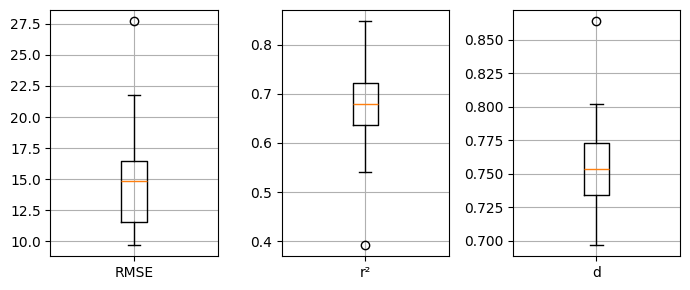

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(7, 3))  # 3 subplots lado a lado

for i, coluna in enumerate(['RMSE', 'r²', 'd']):
    axs[i].boxplot(df_resultados[coluna].values)
    axs[i].set_xticklabels([coluna], rotation=0)
    #axs[i].set_title(f'{coluna}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

#### Espacializando Dados

In [9]:
import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.read_file('aesa/brazil-states.geojson', encoding='utf-8')

# Filtrar para o estado específico (por exemplo, Paraíba)
estado_nome = 'Paraíba'
estado_gdf = gdf[gdf['name'] == estado_nome]

# Definir os limites da área de contorno
contorno = estado_gdf.geometry.iloc[0]
x_min, y_min, x_max, y_max = contorno.bounds

# Criar uma lista para armazenar os pontos dentro do contorno
pontos_dentro_contorno = []

# Definir a quantidade de pontos na grade
num_points = 200  # Aumente este número para uma grade mais fina

# Gerar os pontos dentro da área de contorno
for i in range(num_points):
    for j in range(num_points):
        x = x_min + i * (x_max - x_min) / (num_points - 1)
        y = y_min + j * (y_max - y_min) / (num_points - 1)
        point = Point(x, y)
        if contorno.contains(point):
            pontos_dentro_contorno.append((x, y))

In [12]:
# Criando DataFrame
latlon = []

for i in range(len(pontos_dentro_contorno)):
    for j in range(1, 13):
        for k in range(2015, 2024):
            latlon.append({'Latitude': pontos_dentro_contorno[i][1],
                           'Longitude': pontos_dentro_contorno[i][0],
                           'Ano': k,
                           'Mês': j})

df_esp = pd.DataFrame(latlon)

# Criar a coluna 'latlon' concatenando 'Latitude' e 'Longitude' como strings
df_esp['Localizacao'] = df_esp['Latitude'].astype(str) + ';' + df_esp['Longitude'].astype(str)

# Prever os valores de precipitação para os pontos da grade
df_novos_valores = idw(df_esp['Localizacao'].unique(), df_aesa_t, df_esp, 1)

Faltam 20247 de 20247.


In [14]:
novos_valores_idw = pd.DataFrame(df_novos_valores)

novos_valores_idw['Máximos_C'] = novos_valores_idw['Máximos_IDW'] 
novos_valores_idw['Latitude'] = novos_valores_idw['Latitude'].astype(float)
novos_valores_idw['Longitude'] = novos_valores_idw['Longitude'].astype(float)

# Agrupar pelo 'latlon' e calcular o máximo de 'Máximos_C' para cada grupo
grouped = novos_valores_idw.groupby('Posto').agg({'Latitude': 'first',
                                                  'Longitude': 'first',
                                                  'Máximos_C': 'sum'}).reset_index(drop=True)

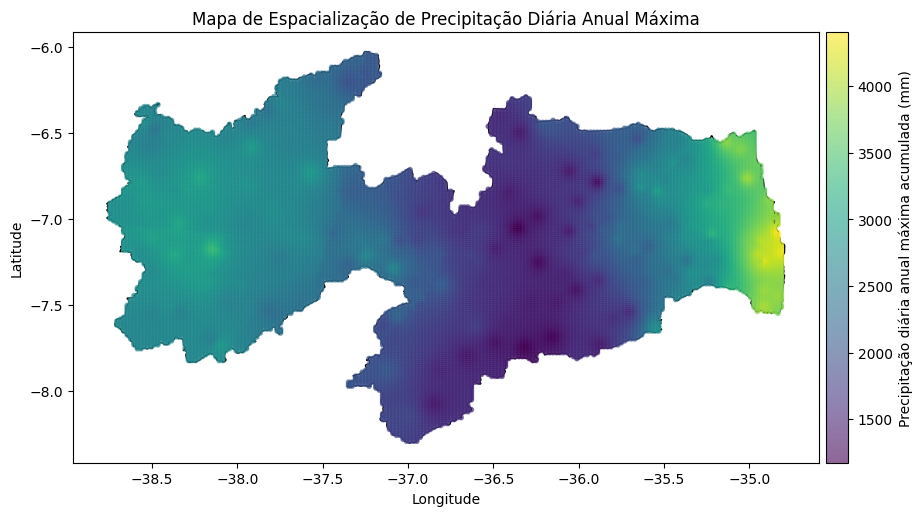

In [15]:
df_esp = grouped.copy()

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o mapa base do estado
estado_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plotar os dados preditos como uma imagem
scatter = ax.scatter(df_esp['Longitude'], df_esp['Latitude'], c=df_esp['Máximos_C'], cmap='viridis', alpha=0.6, s=10)

# Adicionar uma barra de cores
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
cbar.set_label('Precipitação diária anual máxima acumulada (mm)')

# Adicionar títulos e rótulos
plt.title('Mapa de Espacialização de Precipitação Diária Anual Máxima')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o mapa
plt.show()

#### Exportando Resultados

In [16]:
# Exportanto Postos para Espacialização
df_esp.to_csv('results/idw_esp.csv')

# Exportando Acurácias
df_resultados.to_csv('results/idw_acc.csv')

# ESPACIALIZAÇÃO: GRÁFICOS PARA ANÁLISES

#### Configurando Resultados

In [ ]:
import pandas as pd

# Importar arquivos de resultados
dl_accuracy = pd.read_csv('dl_acc.csv')
ml_accuracy = pd.read_csv('ml_acc.csv')
idw_accuracy = pd.read_csv('idw_acc.csv')

# Definir tipos dos DFs
tipos = ['CNNs', 'ExtraTrees', 'IDW']

# 
dfs_accuracy = [dl_accuracy, ml_accuracy, idw_accuracy]

for i, df in enumerate(dfs_accuracy):

    # Adicionar coluna com tipo ao DF
    df['Tipo'] = tipos[i]

# Gerar apenas um DF de acurácia a partir dos arquivos importados
df_accuracy = pd.concat(dfs_accuracy, axis=0)

# Excluir coluna desnecessária
df_accuracy = df_accuracy.drop('Unnamed: 0', axis=1)

df_accuracy[['Latitude', 'Longitude']] = df_accuracy['Posto'].str.split(';', expand=True).astype(float)

# Mantém apenas a primeira linha de cada posto (que terá o maior RMS)
menores_RMSE = df_accuracy.sort_values(by='RMSE', ascending=True).groupby('Posto').first().reset_index()[['Latitude', 'Longitude', 'Tipo']]

# Mantém apenas a primeira linha de cada posto (que terá o maior r²)
maiores_r2 = df_accuracy.sort_values(by='r²', ascending=False).groupby('Posto').first().reset_index()[['Latitude', 'Longitude', 'Tipo']]

# Mantém apenas a primeira linha de cada posto (que terá o maior d)
maiores_d = df_accuracy.sort_values(by='d', ascending=False).groupby('Posto').first().reset_index()[['Latitude', 'Longitude', 'Tipo']]

# Checar resultado
df_accuracy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 48
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Posto      147 non-null    object 
 1   RMSE       147 non-null    float64
 2   r²         147 non-null    float64
 3   d          147 non-null    float64
 4   Tipo       147 non-null    object 
 5   Latitude   147 non-null    float64
 6   Longitude  147 non-null    float64
dtypes: float64(5), object(2)
memory usage: 9.2+ KB


In [2]:
# Importar arquivos de teste
dl_esp = pd.read_csv('results/dl_esp.csv')
ml_esp = pd.read_csv('results/ml_esp.csv')
idw_esp = pd.read_csv('results/idw_esp.csv')

dfs_esp = [dl_esp, ml_esp, idw_esp]

for i in range(len(dfs_esp)):

    # Adicionar coluna com tipo ao DF
    dfs_esp[i]['Tipo'] = tipos[i]

    # Reorganizar DF com colunas necessárias
    dfs_esp[i] = dfs_esp[i][['Tipo', 'Latitude', 'Longitude', 'Máximos_C']].copy()

# Gerar apenas um DF de acurácia a partir dos arquivos importados
dfs_esp = pd.concat(dfs_esp, axis=0)

#### Mapa de Calor

In [3]:
import folium
from folium.plugins import HeatMap
import requests
    
# Inicializar o mapa em uma localização central
m = folium.Map(location=[dfs_esp['Latitude'].median(), dfs_esp['Longitude'].median()], zoom_start=8, width='100%', height='100%')

# Preparar os dados para o HeatMap
heat_data = [[row['Latitude'], row['Longitude'], row['Máximos_C']] for index, row in dfs_esp.iterrows()]

# Adicionar o HeatMap ao mapa
HeatMap(heat_data).add_to(m)

# URL do arquivo GeoJSON contendo as fronteiras dos estados brasileiros
geojson_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
response = requests.get(geojson_url)
geojson_data = response.json()

# Adicionar o polígono da Paraíba ao mapa
folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        'fillColor': 'yellow' if feature['properties']['name'] == 'Paraíba' else 'transparent',
        'color': 'red' if feature['properties']['name'] == 'Paraíba' else 'transparent',
        'weight': 2 if feature['properties']['name'] == 'Paraíba' else 0
    }
).add_to(m)

# Salvar o mapa como um arquivo HTML
# m.save(f'mapas_de_calor/heatmap_paraiba_esp.html')

# Plotando Mapa de Calor
# m

#### Mapas de Espacialização

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point

def espacializacao_1(latitudes, longitudes, precipitacao, titulo):

    # Criar o mapa
    plt.figure(figsize=(8, 8))
    m = Basemap(projection='merc', 
                llcrnrlat=-8.3, urcrnrlat=-6, 
                llcrnrlon=-38.8, urcrnrlon=-34.7, 
                resolution='i')

    # Desenhar as bordas do mapa
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    # Desenhar paralelos e meridianos
    parallels = m.drawparallels(range(-8, -5, 1), labels=[1,0,0,0], fontsize=10)
    meridians = m.drawmeridians(range(-39, -33, 1), labels=[0,0,0,1], fontsize=10)

    # Converter coordenadas para o sistema do mapa
    x, y = m(longitudes, latitudes)

    # Criar o scatter plot com precipitação espacializada
    scatter = m.scatter(x, y, 
                        c=precipitacao, 
                        cmap='viridis', 
                        s=5, 
                        alpha=0.9, 
                        marker='o')

    # Adicionar a barra de cores com tamanho ajustado
    plt.colorbar(scatter, label='Precipitação diária anual máxima acumulada (mm)', fraction=0.026)

    # Adicionar títulos e rótulos
    plt.title(titulo)
    plt.xlabel('Longitude' + ' ' * 125)
    plt.ylabel(' ' * 65 + 'Latitude')

    # Mostrar o mapa
    plt.show()

def espacializacao_2(latitudes, longitudes, precipitacao, titulo):

    # Criar a figura
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plotar o mapa base do estado
    gdf = gpd.read_file('aesa/brazil-states.geojson', encoding='utf-8')
    estado_nome = 'Paraíba'
    estado_gdf = gdf[gdf['name'] == estado_nome]
    estado_gdf.plot(ax=ax, color='white', edgecolor='black')

    # Plotar os dados preditos como uma imagem
    scatter = ax.scatter(longitudes, latitudes, c=precipitacao, cmap='viridis', alpha=0.6, s=10)

    # Adicionar uma barra de cores
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
    cbar.set_label('Precipitação diária anual máxima acumulada (mm)')

    # Adicionar títulos e rótulos
    plt.title(titulo)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Mostrar o mapa
    plt.show()

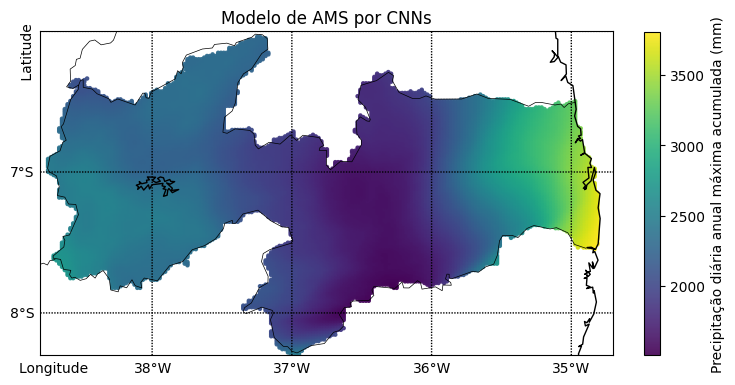

In [5]:
espacializacao_1(dfs_esp[dfs_esp['Tipo'] == 'CNNs']['Latitude'].values,
                 dfs_esp[dfs_esp['Tipo'] == 'CNNs']['Longitude'].values, 
                 dfs_esp[dfs_esp['Tipo'] == 'CNNs']['Máximos_C'].values,
                 'Modelo de AMS por CNNs')

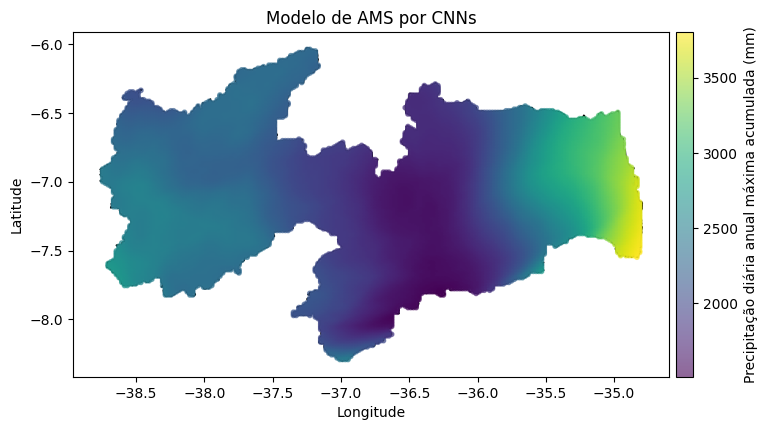

In [6]:
espacializacao_2(dfs_esp[dfs_esp['Tipo'] == 'CNNs']['Latitude'].values,
                 dfs_esp[dfs_esp['Tipo'] == 'CNNs']['Longitude'].values, 
                 dfs_esp[dfs_esp['Tipo'] == 'CNNs']['Máximos_C'].values,
                 'Modelo de AMS por CNNs')

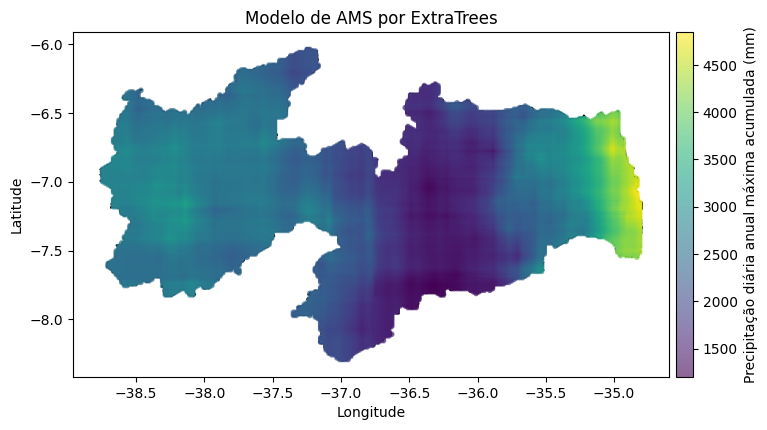

In [7]:
espacializacao_2(dfs_esp[dfs_esp['Tipo'] == 'ExtraTrees']['Latitude'].values,
                 dfs_esp[dfs_esp['Tipo'] == 'ExtraTrees']['Longitude'].values, 
                 dfs_esp[dfs_esp['Tipo'] == 'ExtraTrees']['Máximos_C'].values,
                 'Modelo de AMS por ExtraTrees')

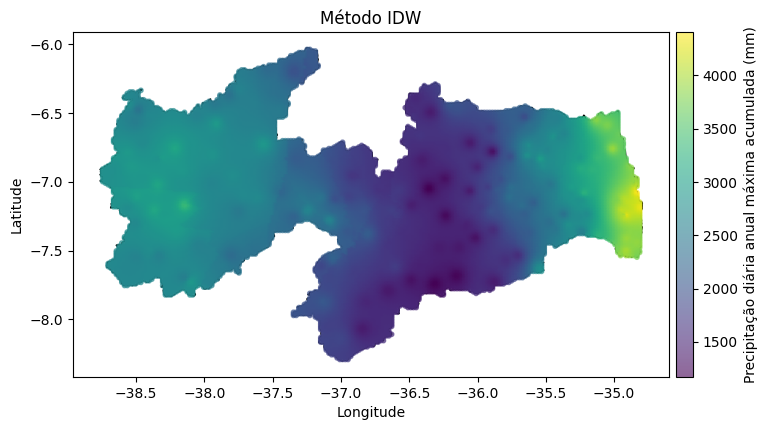

In [8]:
espacializacao_2(dfs_esp[dfs_esp['Tipo'] == 'IDW']['Latitude'].values,
                 dfs_esp[dfs_esp['Tipo'] == 'IDW']['Longitude'].values, 
                 dfs_esp[dfs_esp['Tipo'] == 'IDW']['Máximos_C'].values,
                 'Método IDW')

#### Mapas dos Postos Pluviométricos

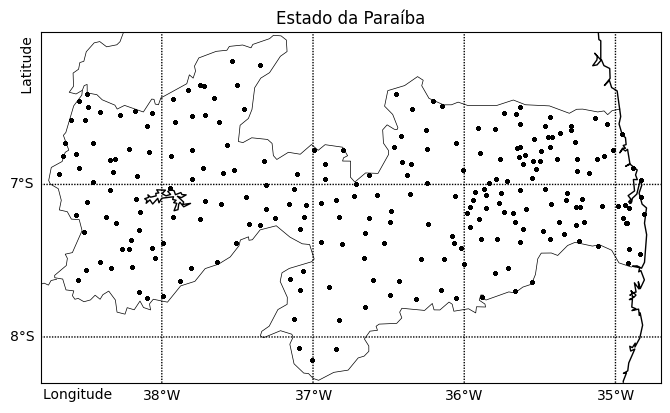

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

# Carregar os dados
df = pd.read_csv('aesa/aesa_2022_tratado.csv')

# Exemplo de dados de precipitação
latitudes = df['Latitude'].values
longitudes = df['Longitude'].values

# Criar o mapa
plt.figure(figsize=(8, 6))
m = Basemap(projection='merc', 
            llcrnrlat=-8.3, urcrnrlat=-6, 
            llcrnrlon=-38.8, urcrnrlon=-34.7, 
            resolution='i')

# Desenhar as bordas do mapa
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Desenhar paralelos e meridianos
parallels = m.drawparallels(range(-8, -5, 1), labels=[1,0,0,0], fontsize=10)
meridians = m.drawmeridians(range(-39, -33, 1), labels=[0,0,0,1], fontsize=10)

# Converter coordenadas para o sistema do mapa
x, y = m(longitudes, latitudes)

# Criar o scatter plot com pontos pretos
m.scatter(x, y, 
          color='black',  # Definir a cor dos pontos como preto
          s=3, 
          marker='o')

# Adicionar títulos e rótulos
plt.title('Estado da Paraíba')
plt.xlabel('Longitude' + ' ' * 125)
plt.ylabel(' ' * 65 + 'Latitude')

# Mostrar o mapa
plt.show()

#### Mapa de Distribuição de Melhores Estações dos Pontos

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def m_postos(df, titulo, ax):
    colors = {
        'IDW': 'blue',
        'ExtraTrees': 'orange',
        'CNNs': 'red'
    }

    # Criar o gráfico de pontos no objeto Axes fornecido
    m = Basemap(projection='merc', llcrnrlat=-8.3, urcrnrlat=-6, llcrnrlon=-38.8, urcrnrlon=-34.7, resolution='i', ax=ax)

    # Desenhar as bordas do mapa
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    for tipo in colors:
        x, y = m(df[df['Tipo'] == tipo]['Longitude'].values, 
                 df[df['Tipo'] == tipo]['Latitude'].values)
        m.scatter(x, y, label=tipo, color=colors[tipo], alpha=0.7, s=25)

    # Desenhar paralelos e meridianos
    parallels = m.drawparallels(range(-8, -5, 1), labels=[1,0,0,0], fontsize=10)
    meridians = m.drawmeridians(range(-39, -33, 1), labels=[0,0,0,1], fontsize=10)

    ax.set_title(titulo)
    ax.set_xlabel('Longitude' + ' ' * 120)
    ax.set_ylabel(' ' * 63 + 'Latitude')
    ax.legend()

    # Remover as grades
    ax.grid(False)

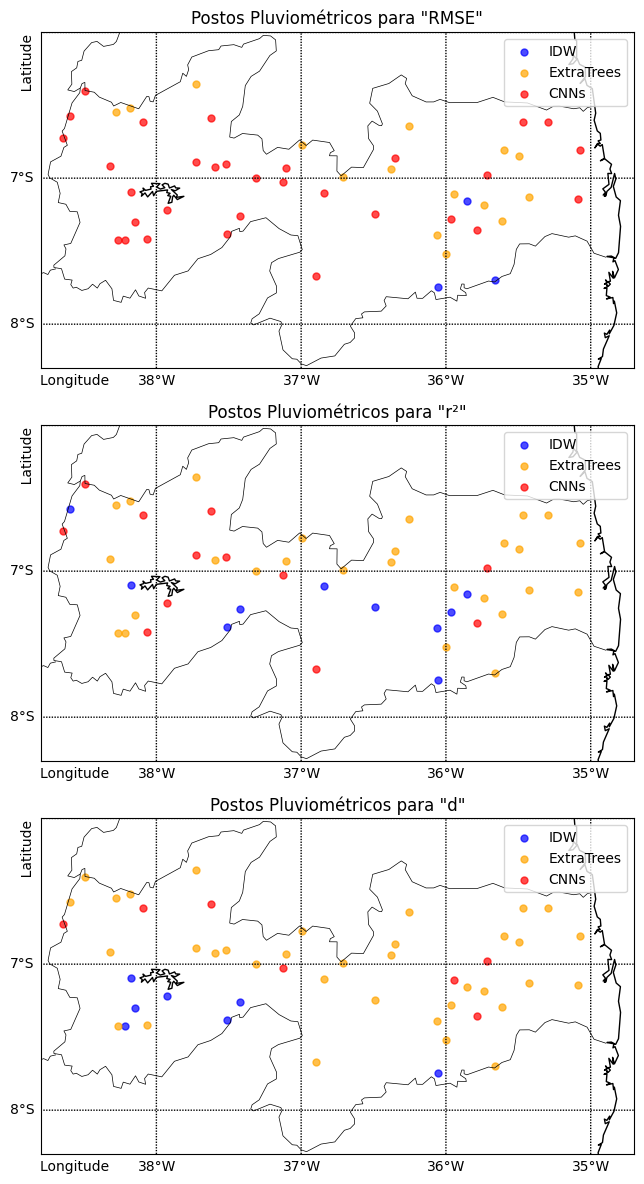

In [35]:
# Supondo que df1 e df2 sejam seus DataFrames
fig, axs = plt.subplots(3, 1, figsize=(11.94, 11.94))

# RMSE
m_postos(menores_RMSE, 'Postos Pluviométricos para "RMSE"', axs[0])

# r² = d
m_postos(maiores_r2, 'Postos Pluviométricos para "r²"', axs[1])

# r² = d
m_postos(maiores_d, 'Postos Pluviométricos para "d"', axs[2])

plt.tight_layout()
plt.show()

#### BoxPlot das Melhores Acurácias

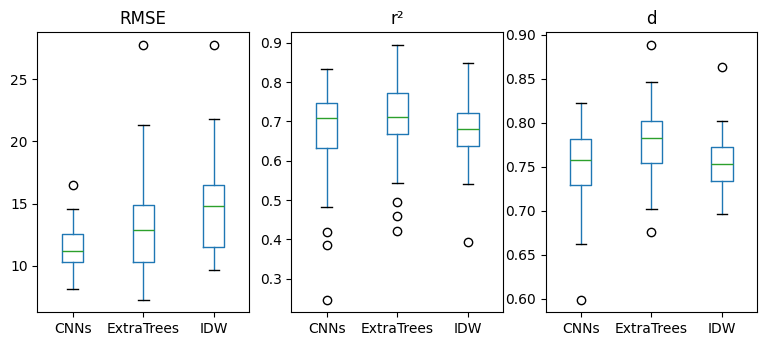

In [12]:
import matplotlib.pyplot as plt

# Criar os gráficos boxplot
fig, axs = plt.subplots(1, 3, figsize=(9, 4))

# RMSE
df_accuracy.boxplot(column='RMSE', by='Tipo', ax=axs[0])
axs[0].set_title('RMSE')
axs[0].set_xlabel('')
axs[0].grid(False)

# r²
df_accuracy.boxplot(column='r²', by='Tipo', ax=axs[1])
axs[1].set_title('r²')
axs[1].set_xlabel('')
axs[1].grid(False)

# MSE
df_accuracy.boxplot(column='d', by='Tipo', ax=axs[2])
axs[2].set_title('d')
axs[2].set_xlabel('')
axs[2].grid(False)

# Remover legenda
plt.subplots_adjust(bottom=0.2)

plt.suptitle('')
plt.show()